In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics

from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [93]:
df_ls=[]
coin_ls=['BNB','BTC','DOGE','ETH','LTC','SOL']
for coin in coin_ls:
    df=pd.read_csv(f'data/data_{coin}-USD.csv')
    df['ret']=(np.log(df.Close)-np.log(df.Close.shift(1))).shift(-1)
    df['cum_ret']=df.ret.cumsum()
    df=df.dropna()
    df_ls.append(df)
coin_dict=dict(zip(coin_ls,df_ls))

In [54]:
gbm = np.log( 1000 + np.cumsum(     np.random.randn( 100000 ) ) )  # a Geometric Brownian Motion[log(1000 + rand), log(1000 + rand + rand ), log(1000 + rand + rand + rand ),... log(  1000 + rand + ... )]
mr  = np.log( 1000 +                np.random.randn( 100000 )   )  # a Mean-Reverting Series    [log(1000 + rand), log(1000 + rand        ), log(1000 + rand               ),... log(  1000 + rand       )]
tr  = np.log( 1000 + np.cumsum( 1 + np.random.randn( 100000 ) ) )  # a Trending Series          [log(1001 + rand), log(1002 + rand + rand ), log(1003 + rand + rand + rand ),... log(101000 + rand + ... )]
                  

In [71]:
def genhurst(S,q):

    L=len(S)       
    if L < 100:
        warnings.warn('Data series very short!')
        return np.nan
       
    H = np.zeros((len(range(5,20)),1))
    k = 0
    
    for Tmax in range(5,10):
        
        x = np.arange(1,Tmax+1,1)
        mcord = np.zeros((Tmax,1))
        
        for tt in range(1,Tmax+1):
            dV = S[np.arange(tt,L,tt)] - S[np.arange(tt,L,tt)-tt] 
            VV = S[np.arange(tt,L+tt,tt)-tt]
            N = len(dV) + 1
            X = np.arange(1,N+1,dtype=np.float64)
            Y = VV
            mx = np.sum(X)/N
            SSxx = np.sum(X**2) - N*mx**2
            my = np.sum(Y)/N
            SSxy = np.sum( np.multiply(X,Y))  - N*mx*my
            cc1 = SSxy/SSxx
            cc2 = my - cc1*mx
            ddVd = dV - cc1
            VVVd = VV - np.multiply(cc1,np.arange(1,N+1,dtype=np.float64)) - cc2
            mcord[tt-1] = np.mean( np.abs(ddVd)**q )/np.mean( np.abs(VVVd)**q )
            
        mx = np.mean(np.log10(x))
        SSxx = np.sum( np.log10(x)**2) - Tmax*mx**2
        my = np.mean(np.log10(mcord))
        SSxy = np.sum( np.multiply(np.log10(x),np.transpose(np.log10(mcord)))) - Tmax*mx*my
        H[k] = SSxy/SSxx
        k = k + 1
        
    mH = np.mean(H)/q
    
    return mH

In [111]:
print ( "HurstEXP( Geometric Browian Motion ):   {0: > 12.8f}".format( genhurst( gbm,5 ) ) )
print ( "HurstEXP(    Mean-Reverting Series ):   {0: > 12.8f}".format( genhurst( mr,5  ) ) )
print ( "HurstEXP(          Trending Series ):   {0: > 12.8f}".format( genhurst( tr,5 ) ) )

HurstEXP( Geometric Browian Motion ):     0.50085159
HurstEXP(    Mean-Reverting Series ):     0.00092290
HurstEXP(          Trending Series ):     0.78679053


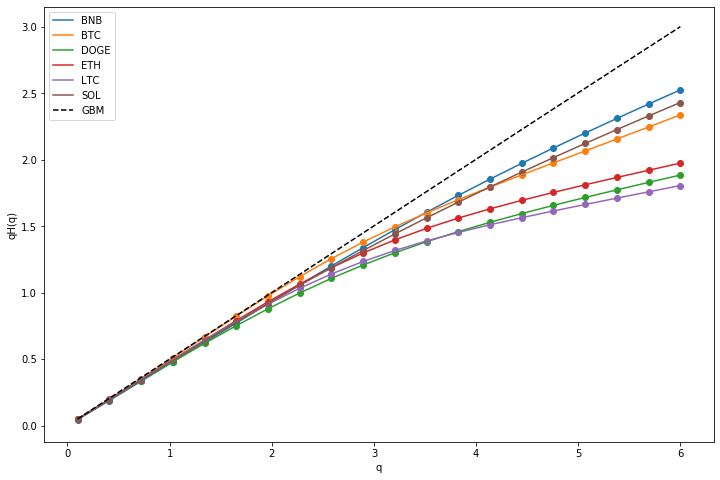

In [167]:
plt.subplots(1,1,figsize=(12,8))
for key, values in coin_dict.items():
    q = np.linspace(0.1,6,20)
    Hq = [genhurst(values.cum_ret.values,qq)*qq for qq in q]
    plt.plot(q,Hq,label=key)
    plt.scatter(q,Hq)
Hq=[genhurst(gbm,qq)*qq for qq in q]
plt.plot(q,Hq,'k--',label='GBM')
plt.xlabel('q')
plt.ylabel('qH(q)')
plt.legend()

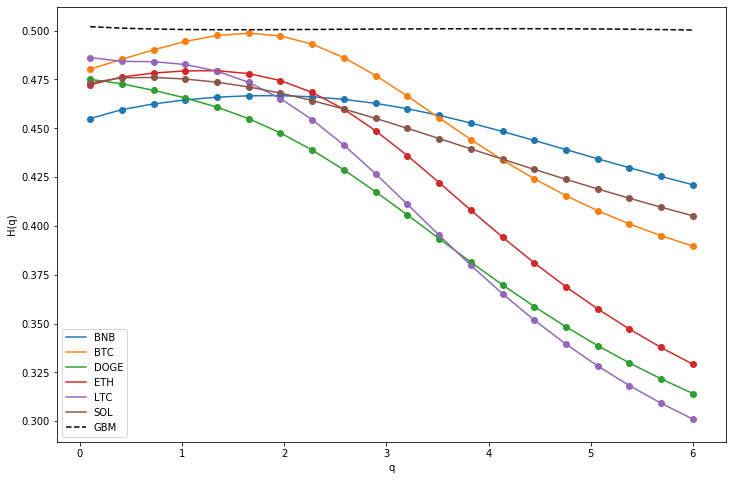

In [170]:
plt.subplots(1,1,figsize=(12,8))
for key, values in coin_dict.items():
    q = np.linspace(0.1,6,20)
    H = [genhurst(values.cum_ret.values,qq) for qq in q]
    plt.plot(q,H,label=key)
    plt.scatter(q,H)
H=[genhurst(gbm,qq) for qq in q]
plt.plot(q,H,'k--',label='GBM')
plt.xlabel('q')
plt.ylabel('H(q)')
plt.legend()

In [95]:
for key, values in coin_dict.items():
    print(genhurst(values.cum_ret.values,10))

0.3823041788803254
0.35383656493325966
0.2586311455121168
0.26608673609444494
0.2439956746644954
0.3625749943013501


In [181]:
df=pd.read_csv(f'data/data_BTC-USD.csv')
df['ret']=(np.log(df.Close)-np.log(df.Close.shift(1)))
df['cum_ret']=df.ret.cumsum()
df=df.dropna()

In [182]:
hurst_ls=[]
rolling_ret_ls=[]
for t in range(200,len(df)):
    sub_df=df[t-200:t]
    hurst=genhurst(sub_df.cum_ret.values,1)
    rolling_ret=sub_df.ret.mean()
    hurst_ls.append(hurst)
    rolling_ret_ls.append(rolling_ret)

In [183]:
df['hurst']=[0]*200+hurst_ls
df['rolling_ret']=[0]*200+rolling_ret_ls

In [184]:
df['action']=0

In [185]:
df['action'].loc[(df['hurst'] > 0.55) & (df['rolling_ret']>0)]=1
df['action'].loc[(df['hurst'] > 0.55) & (df['rolling_ret']<0)]=-1
df['action'].loc[(df['hurst'] < 0.55) & (df['rolling_ret']>0)]=-1
df['action'].loc[(df['hurst'] < 0.55) & (df['rolling_ret']<0)]=1

In [186]:
df['hurst_ret']=df['ret']*df['action']

Text(0, 0.5, 'Action')

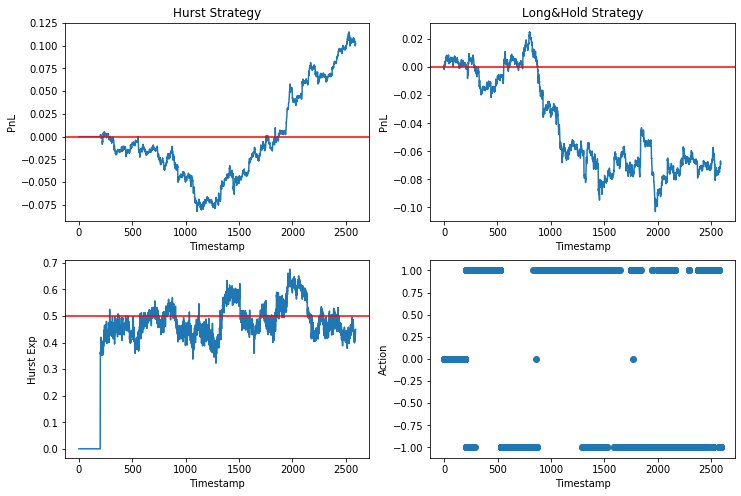

In [187]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
ax[0][0].plot(df['hurst_ret'].cumsum())
ax[0][0].axhline(y=0, color='r', linestyle='-')
ax[0][0].set_title('Hurst Strategy')
ax[0][0].set_xlabel('Timestamp')
ax[0][0].set_ylabel('PnL')


ax[0][1].plot(df['cum_ret'])
ax[0][1].axhline(y=0, color='r', linestyle='-')
ax[0][1].set_title('Long&Hold Strategy')
ax[0][1].set_xlabel('Timestamp')
ax[0][1].set_ylabel('PnL')


ax[1][0].plot(df['hurst'])
ax[1][0].axhline(y=0.5, color='r', linestyle='-')
ax[1][0].set_xlabel('Timestamp')
ax[1][0].set_ylabel('Hurst Exp')


ax[1][1].scatter(range(len(df)),df['action'])
ax[1][1].set_xlabel('Timestamp')
ax[1][1].set_ylabel('Action')